In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from tqdm.notebook import tqdm
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from pymystem3 import Mystem
from nltk.stem.wordnet import WordNetLemmatizer
plt.rcParams['figure.figsize'] = 15, 5

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Polad_Babashev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Polad_Babashev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Polad_Babashev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# EDA

## Tjonral

In [106]:
df_tjornal = pd.read_csv('tjornal.csv')

In [66]:
df_tjornal.head()

,article_url,article_time,article_head,article_content
0,https://tjournal.ru/u/274224-anatoliy-tihvinsk...,11.11.2019 17:33,ИСКУССТВЕННЫЙ ИНТЕЛЛЕКТ,Люди создали Искусственный Интеллект и открыл...
1,https://tjournal.ru/internet/131681-iskusstven...,18.12.2019 00:15,Искусственный интеллект,
2,https://tjournal.ru/tech/125621-iskusstvennyy-...,14.11.2019 04:41,Искусственный интеллект обучили копировать чуж...,
3,https://tjournal.ru/news/116219-vkontakte-vper...,13.09.2019 12:38,«ВКонтакте» впервые откроет научную лаборатори...,Кураторами лаборатории станут разработчики ко...
4,https://tjournal.ru/tech/131933-kazhdyy-iz-nih...,23.12.2019 11:35,Каждый из них играл за человечество: история п...,22 года развития ИИ в хронологии матчей – от ...


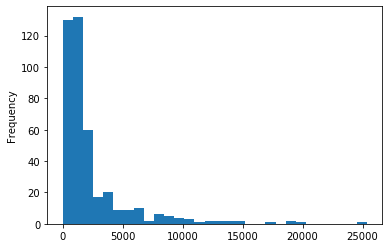

In [107]:
df_tjornal.article_content.dropna().apply(lambda x: len(x)).plot(kind='hist', bins=30)

## Meduza

In [84]:
df_meduza = pd.read_csv('meduza.csv', parse_dates=['article_time'])

In [57]:
df_meduza.head()

,article_url,article_time,article_head,article_content
0,https://meduza.io/feature/2020/01/16/meduzoid-...,2020-01-16 16:55:00,«Медузоид» из сердца крысы и киборги из лягуша...,Исследователи из Университета Тафстса Новая ра...
1,https://meduza.io/slides/nevidimaya-klaviatura...,2020-01-11 16:03:00,"Невидимая клавиатура, крадущийся автомобиль-кр...",Каждый год на проходящей в Лас-Вегасе технолог...
2,https://meduza.io/slides/20-luchshih-russkih-i...,2020-01-03 06:42:00,20 лучших русских и иностранных книг за десяти...,«Медуза» продолжает подводить итоги десятилети...
3,https://meduza.io/slides/razve-mozhet-robot-na...,2019-12-30 12:16:00,Откуда искусственный интеллект берет вдохновен...,В 2018 году на аукционе Christieʼs Иногда гово...
4,https://meduza.io/episodes/2019/12/27/novye-ch...,2019-12-27 15:00:00,"Новые черные дыры, аэромобили и другие приятны...",Несколько месяцев подряд в подкасте «Так и буд...


In [87]:
df_meduza.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 4 columns):
article_url        507 non-null object
article_time       507 non-null datetime64[ns]
article_head       507 non-null object
article_content    506 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 16.0+ KB


In [97]:
[type(df_meduza.article_content.values[i]) for i in range(df_meduza.shape[0])].index(float)

35

In [98]:
df_meduza.article_content.values[35]

nan

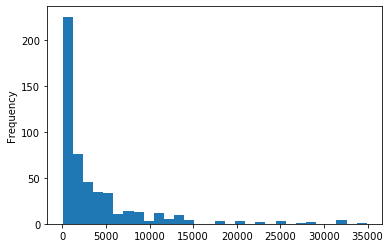

In [101]:
df_meduza.article_content.dropna().apply(lambda x: len(x)).plot(kind='hist', bins=30)

In [64]:
df.article_content.apply(lambda x: len(x)).describe()

count      420.000000
mean      2417.942857
std       3315.352135
min          1.000000
25%        680.500000
50%       1320.000000
75%       2386.250000
max      25352.000000
Name: article_content, dtype: float64

In [17]:
df_meduza.head().T

,0,1,2,3,4
article_url,https://meduza.io/feature/2020/01/16/meduzoid-...,https://meduza.io/slides/nevidimaya-klaviatura...,https://meduza.io/slides/20-luchshih-russkih-i...,https://meduza.io/slides/razve-mozhet-robot-na...,https://meduza.io/episodes/2019/12/27/novye-ch...
article_time,"16:55, 16 января","16:03, 11 января","06:42, 3 января","12:16, 30 декабр","15:00, 27 декабр"
article_head,«Медузоид» из сердца крысы и киборги из лягуша...,"Невидимая клавиатура, крадущийся автомобиль-кр...",20 лучших русских и иностранных книг за десяти...,Откуда искусственный интеллект берет вдохновен...,"Новые черные дыры, аэромобили и другие приятны..."
article_content,Исследователи из Университета Тафстса Новая ра...,Каждый год на проходящей в Лас-Вегасе технолог...,«Медуза» продолжает подводить итоги десятилети...,В 2018 году на аукционе Christieʼs Иногда гово...,Несколько месяцев подряд в подкасте «Так и буд...


## N+1


In [68]:
df_nplus = pd.read_csv('nplus.csv', parse_dates=['article_time'])

In [73]:
df_nplus.head(200)

,article_url,article_time,article_head,article_content
0,https://nplus1.ru/news/2016/06/20/ai-ant-soccer,2016-06-20 14:28:27,Искусственный интеллект Google сыграл в «мурав...,DeepMind / YouTube Искусственный интеллект ...
1,https://nplus1.ru/news/2018/04/24/nuclear,2018-04-24 11:40:12,Искусственный интеллект назвали угрозой ядерно...,Ядерные испытания в Неваде в 1957 году U.S....
2,https://nplus1.ru/news/2016/11/14/ai-learns-ab...,2016-11-14 13:07:37,Искусственный интеллект научился взвешивать об...,The Marmot / Flickr Искусственный интеллект...
3,https://nplus1.ru/news/2016/10/25/AI-predict,2016-10-25 12:21:12,Искусственный интеллект научился предсказывать...,Adrian Grycuk / Wikimedia Commons Искусстве...
4,https://nplus1.ru/news/2016/06/10/yeah-skynet,2016-06-10 10:17:11,Искусственный интеллект игры Elite Dangerous р...,Deebz__ / YouTune После обновления игры Eli...
...,...,...,...,...
195,https://nplus1.ru/news/2017/10/30/suicide-mach...,2017-10-30 16:00:33,Машинное обучение вычислило потенциальных само...,"Джон Эверетт Милле «Офелия»,1852 год public..."
196,https://nplus1.ru/news/2016/05/05/neoneo,2016-05-05 11:53:23,Компьютер обошел человека в неорганическом син...,"Блок-схема, суммирующая предсказания систем..."
197,https://nplus1.ru/news/2017/12/14/gfycat,2017-12-14 09:53:23,Машинное обучение улучшит качество гифок,Gfycat Сервис для хранения и создания аними...
198,https://nplus1.ru/news/2017/01/13/raisr,2017-01-13 08:55:59,Машинное обучение улучшило картинки в Google+,Фотография заката в формате JPEG с уменьшен...


In [72]:
df_nplus.tail().article_head.values[1]

'Что интеллект? Игра!'

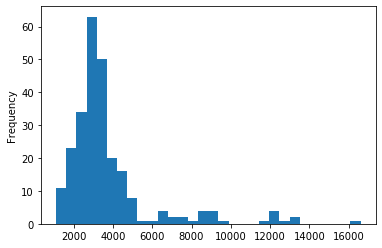

In [83]:
df_nplus.article_content.apply(lambda x: len(x)).plot(kind='hist', bins=30)

## ALL

In [69]:
files = ['meduza.csv', 'tjornal.csv', 'nplus.csv']
df = pd.concat([pd.read_csv(i, parse_dates=['article_time']) for i in files]).dropna().drop_duplicates(subset='article_url')

In [70]:
df.shape

(1042, 4)

In [15]:
df.head()

,article_url,article_time,article_head,article_content
0,https://meduza.io/feature/2020/01/16/meduzoid-...,2020-01-16 16:55:00,«Медузоид» из сердца крысы и киборги из лягуша...,Исследователи из Университета Тафстса Новая ра...
1,https://meduza.io/slides/nevidimaya-klaviatura...,2020-01-11 16:03:00,"Невидимая клавиатура, крадущийся автомобиль-кр...",Каждый год на проходящей в Лас-Вегасе технолог...
2,https://meduza.io/slides/20-luchshih-russkih-i...,2020-01-03 06:42:00,20 лучших русских и иностранных книг за десяти...,«Медуза» продолжает подводить итоги десятилети...
3,https://meduza.io/slides/razve-mozhet-robot-na...,2019-12-30 12:16:00,Откуда искусственный интеллект берет вдохновен...,В 2018 году на аукционе Christieʼs Иногда гово...
4,https://meduza.io/episodes/2019/12/27/novye-ch...,2019-12-27 15:00:00,"Новые черные дыры, аэромобили и другие приятны...",Несколько месяцев подряд в подкасте «Так и буд...


In [16]:
df.sort_values('article_time', inplace=True)

In [17]:
df.article_time.dt.year.value_counts()

2019    367
2017    269
2018    260
2016    208
2015     64
2020      8
2014      5
Name: article_time, dtype: int64

In [76]:
df.article_time = df.article_time.dt.year

## Time analysis

In [77]:
stops = list(stopwords.words('russian'))

In [78]:
stem = Mystem()
lem = WordNetLemmatizer()

### 2015

In [80]:
df15 = df.query('article_time == 2015')

In [81]:
df15.head()

,article_url,article_time,article_head,article_content
269,https://meduza.io/feature/2015/12/17/26-letniy...,2015,26-летний хакер собрал беспилотную машину. За ...,"Автомобили, способные ездить без участия челов..."
270,https://meduza.io/news/2015/12/12/ilon-mask-ob...,2015,Илон Маск объявил о создании НКО для исследова...,Основатель Tesla Motors и SpaceX Илон Маск объ...
271,https://meduza.io/quiz/kto-dovolnee-putin-ili-...,2015,Кто довольнее: Путин или Обама?,"Microsoft запустила сервис, в котором робот уг..."
272,https://meduza.io/feature/2015/11/02/lyudi-ne-...,2015,"«Люди не заняты исламом, христианством, иудаиз...",Проект «Открытая библиотека» в Санкт-Петербург...
273,https://meduza.io/shapito/2015/10/28/issledova...,2015,Исследователи научили Wi-Fi различать силуэты ...,Исследователи из Массачусетского технологическ...


In [82]:
texts = [word_tokenize(re.sub('[^А-яA-z ]+', ' ', txt.lower())) for txt in tqdm(df15.article_content.values)]

In [83]:
stemmer = SnowballStemmer("russian")
texts_prepared = [' '.join([word for word in text if word not in stops]) for text in tqdm(texts)]

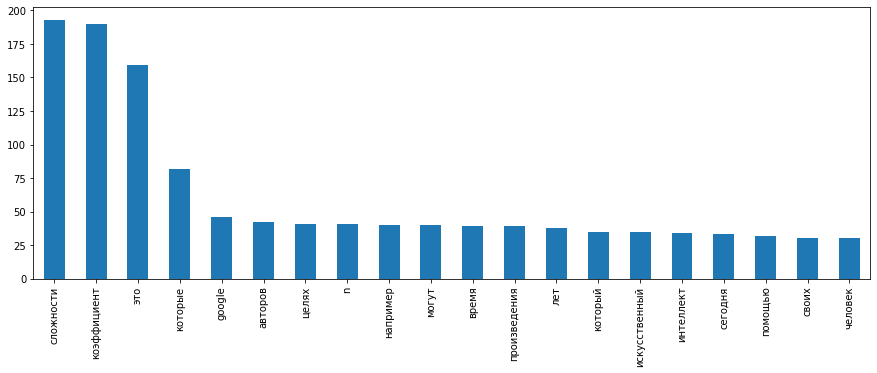

In [84]:
pd.Series(' '.join(texts_prepared).split(' ')).value_counts().head(20).plot(kind='bar')

### 2016

In [85]:
df16 = df.query('article_time == 2016')

In [86]:
df16.head()

,article_url,article_time,article_head,article_content
211,https://meduza.io/cards/data-science-eto-voobs...,2016,Data Science — это вообще работает?,"Вообще говоря, Data Science — это набор конкре..."
212,https://meduza.io/news/2016/12/23/avril-lavin-...,2016,Аврил Лавин попросила Марка Цукерберга не оско...,Певица Аврил Лавин заступилась за группу Nicke...
213,https://meduza.io/shapito/2016/12/21/dzharvis-...,2016,"Джарвис, пришли футболку",В начале 2016 года основатель Facebook Марк Цу...
214,https://meduza.io/news/2016/12/19/zhurnal-natu...,2016,Журнал Nature включил создателя пиратского сай...,"Александра Элбакян из Казахстана, создавшая пи..."
215,https://meduza.io/feature/2016/12/17/vse-zakon...,2016,Все законы робототехники,Глава совета директоров Mail.Ru и основатель к...


In [87]:
texts = [word_tokenize(re.sub('[^А-яA-z ]+', ' ', txt.lower())) for txt in tqdm(df16.article_content.values)]

In [88]:
stemmer = SnowballStemmer("russian")
texts_prepared = [' '.join([word for word in text if word not in stops]) for text in tqdm(texts)]

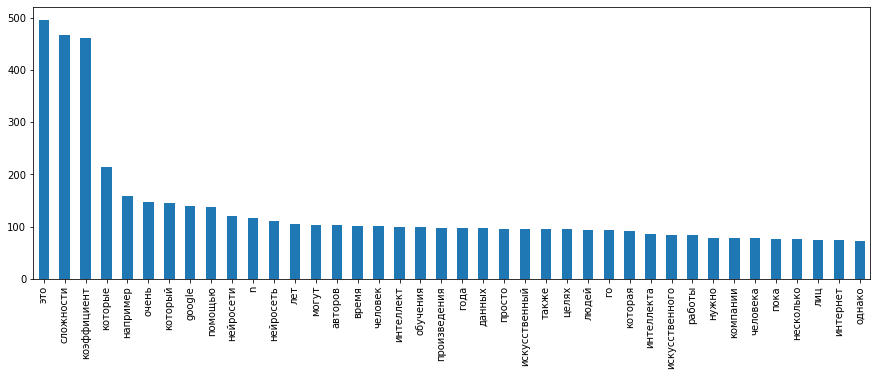

In [89]:
pd.Series(' '.join(texts_prepared).split(' ')).value_counts().head(40).plot(kind='bar')

### 2017

In [90]:
df17 = df.query('article_time == 2017')

In [91]:
df17.head()

,article_url,article_time,article_head,article_content
150,https://meduza.io/feature/2017/12/22/pyat-neoc...,2017,Пять неочевидных причин все же прочитать «Прои...,На русском языке 22 декабря выходит роман Дэна...
151,https://meduza.io/news/2017/12/15/nasa-nashlo-...,2017,Ученые NASA нашли экзопланеты с помощью нейрос...,NASA сообщило об обнаружении экзопланет в сист...
152,https://meduza.io/shapito/2017/12/13/ron-byl-g...,2017,"«Рон был громкой, медлительной, мягкой птичкой...",Чикагская студия Botnik В произведении нейросе...
153,https://meduza.io/shapito/2017/12/12/storyboar...,2017,Storyboard: экспериментальное приложение от Go...,Корпорация Google выпустила экспериментальное ...
154,https://meduza.io/feature/2017/12/09/zhurnalis...,2017,Журналист написал научно-фантастический расска...,Канадский журналист и писатель Стивен Марч нап...


In [92]:
texts = [word_tokenize(re.sub('[^А-яA-z ]+', ' ', txt.lower())) for txt in tqdm(df17.article_content.values)]

In [93]:
stemmer = SnowballStemmer("russian")
texts_prepared = [' '.join([word for word in text if word not in stops]) for text in tqdm(texts)]

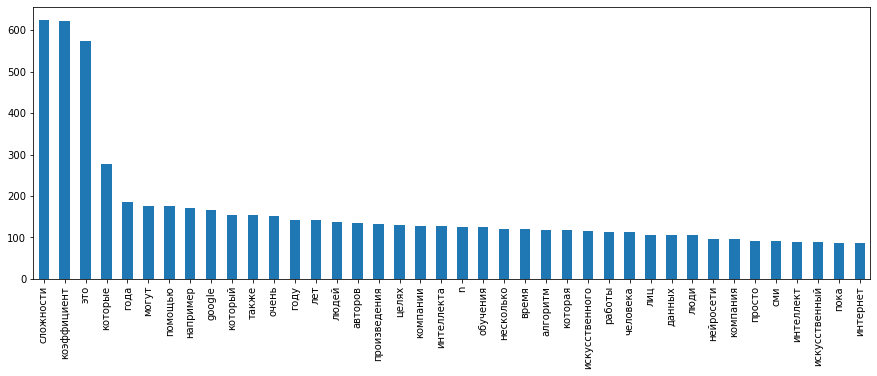

In [94]:
pd.Series(' '.join(texts_prepared).split(' ')).value_counts().head(40).plot(kind='bar')

### 2018

In [95]:
df18 = df.query('article_time == 2018')

In [96]:
df18.head()

,article_url,article_time,article_head,article_content
96,https://meduza.io/slides/kak-nevidimye-roboty-...,2018,"Справки, выписки, проверки — все это можно дов...","В каждой компании есть процессы, состоящие из ..."
97,https://meduza.io/games/smozhete-li-vy-stat-da...,2018,Сможете ли вы стать data-специалистом?,"Если верить сайтам с вакансиями, data-специали..."
98,https://meduza.io/feature/2018/12/17/lyudi-sno...,2018,Люди снова проиграли искусственному интеллекту...,Команда Microsoft В конкурсе участвовали пять ...
99,https://meduza.io/shapito/2018/12/12/rossiya-2...,2018,«Россия 24» рассказала о «самых современных ро...,Телеканал «Россия 24» в сюжете про всероссийск...
100,https://meduza.io/news/2018/12/11/sberbank-moz...,2018,Сбербанк может отказаться от слова «банк» в на...,Из названия Сбербанка может исчезнуть вторая ч...


In [97]:
texts = [word_tokenize(re.sub('[^А-яA-z ]+', ' ', txt.lower())) for txt in tqdm(df18.article_content.values)]

In [98]:
stemmer = SnowballStemmer("russian")
texts_prepared = [' '.join([word for word in text if word not in stops]) for text in tqdm(texts)]

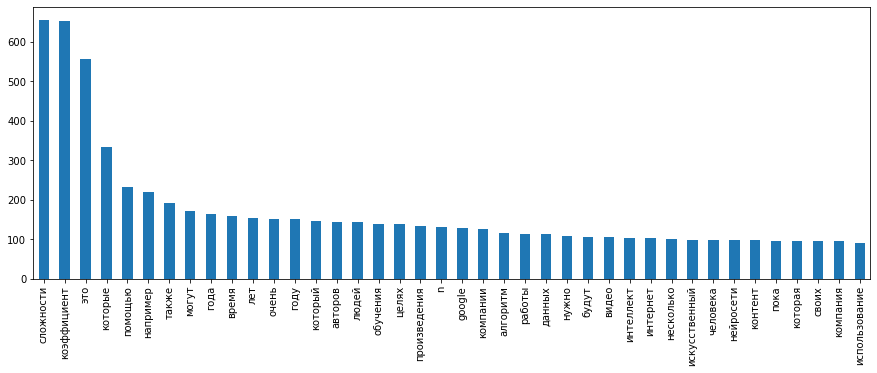

In [99]:
pd.Series(' '.join(texts_prepared).split(' ')).value_counts().head(40).plot(kind='bar')

### 2019

In [100]:
df19 = df.query('article_time == 2019')

In [101]:
df19.head()

,article_url,article_time,article_head,article_content
3,https://meduza.io/slides/razve-mozhet-robot-na...,2019,Откуда искусственный интеллект берет вдохновен...,В 2018 году на аукционе Christieʼs Иногда гово...
4,https://meduza.io/episodes/2019/12/27/novye-ch...,2019,"Новые черные дыры, аэромобили и другие приятны...",Несколько месяцев подряд в подкасте «Так и буд...
5,https://meduza.io/feature/2019/12/27/rossiyski...,2019,Российский технологический университет ввел за...,В ходе зимней сессии 2019 года две тысячи студ...
6,https://meduza.io/news/2019/12/25/mts-razrabot...,2019,МТС разработала умную колонку и голосового пом...,"МТС разработала умную колонку, голосового помо..."
7,https://meduza.io/shapito/2019/12/23/mark-tsuk...,2019,Марк Цукерберг отказался от интервью с The Gua...,Раньше основатель Facebook Марк Цукерберг не л...


In [102]:
texts = [word_tokenize(re.sub('[^А-яA-z ]+', ' ', txt.lower())) for txt in tqdm(df19.article_content.values)]

In [103]:
stemmer = SnowballStemmer("russian")
texts_prepared = [' '.join([word for word in text if word not in stops]) for text in tqdm(texts)]

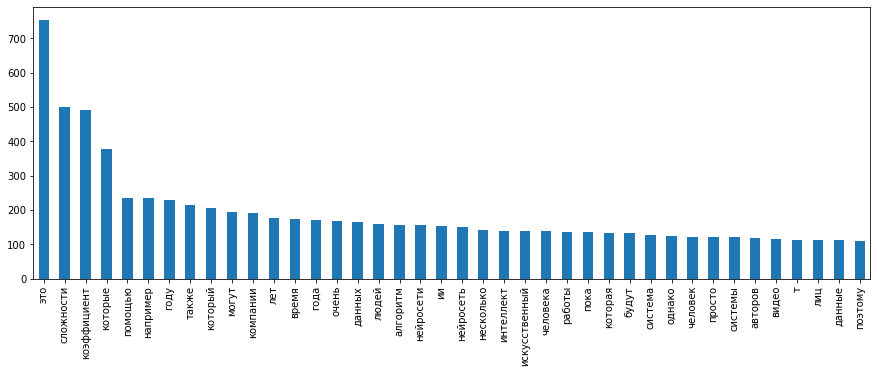

In [104]:
pd.Series(' '.join(texts_prepared).split(' ')).value_counts().head(40).plot(kind='bar')